# Assignment 1 Part 2: Ray SDF Intersection

In this assignment, we covered ray-triangle intersection and ray-volume (density grid) intersection. Let's implement one more geometry representation: Signed Distance Fields (SDFs), and implement ray-SDF intersection using sphere tracing.

In [1]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt

import slangpy as spy
from pyglm import glm
import open3d as o3d
from tqdm.notebook import tqdm

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.cameras import PerspectiveCamera
from cs248a_renderer.renderer.core_renderer import Renderer
from cs248a_renderer.model.transforms import Transform3D

objc[36409]: Class GLFWHelper is implemented in both /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x11c66d248) and /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x12f80fa28). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[36409]: Class GLFWApplicationDelegate is implemented in both /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x11c66d298) and /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x12f80fa78). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[36409]

In [2]:
# We setup the device and renderer similar to part 1
device = setup_device([])
renderer_modules = RendererModules(device)

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.
[WARN] Slang compiler warnings:
/Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/src/cs248a_renderer/slang_shaders/renderer.slang(65): warning 41016: use of uninitialized variable 'result'
    float3 color = simpleMaterial.shade(ray, result);
                                       ^
/Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/src/cs248a_renderer/slang_shaders/renderer.slang(59): warning 41016: use of uninitialized variable 'result'
        return float4(result.normal * 0.5 + 0.5, 1.0);
                                    ^
/Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/src/cs248a_renderer/slang_shaders/renderer.slang(53): warning 41016: use of uninitialized variable 'result'
        return float4(float3(result.t), 1.0);
                            ^



In [3]:
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)
renderer = Renderer(
    device=device,
    render_texture=output_image,
    render_modules=renderer_modules
)

In [4]:
cam = PerspectiveCamera()
cam.transform.position = glm.vec3(0.0, 0.0, 3.0)
cam.transform.rotation = glm.quat(1.0, 0.0, 0.0, 0.0)

## Render Sphere SDF

The first SDF we will implement is a sphere SDF. Read `ISDF` interface in `src/cs248a_renderer/slang_shaders/primitive/sdf.slang`. Each SDF is defined with two methods: `sdf` and `normal`.

A sphere SDF is defined by its center and radius. Each `sdf` also has a 4x4 `invModelMatrix` that transforms a point from world space to the object space of the SDF.

In the following cell, we created one sphere centered at (0, 0, 0) with radius 1. Implement the `sdf` and `normal` methods for the sphere SDF.

In [5]:
# Create sphere SDF buffer
sphere_sdfs = spy.NDBuffer(
    device=device,
    dtype=renderer_modules.primitive_module.SphereSDF.as_struct(),
    shape=(1,),
)

sphere_cursor = sphere_sdfs.cursor()
sphere_cursor[0].write({
    "center": [0.0, 0.0, 0.0],
    "radius": 1.0,
    "invModelMatrix": glm.mat4(1.0),
})
sphere_cursor.apply()

Now, extend the `sample` function in `src/cs248a_renderer/slang_shaders/renderer.slang` to implement the sphere tracing algorithm for ray-SDF intersection. You can refer to the 46 slides of Lecture 4 for the algorithm details.

If you implemented the SDF function and the sphere tracing algorithm correctly, you should be able to see the rendered sphere as below:

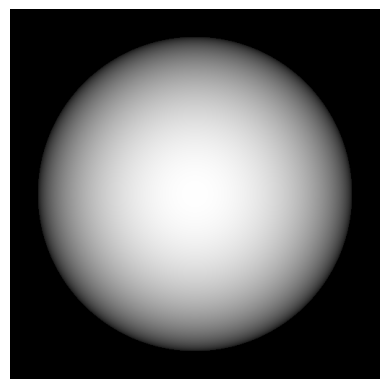

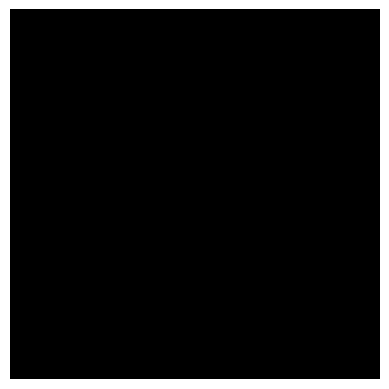

In [6]:
renderer.load_sdf_spheres(sphere_buffer=sphere_sdfs, sphere_count=1)
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Render Cube SDF

Next, implement the cube SDF in `src/cs248a_renderer/slang_shaders/primitive/sdf.slang` as well. You should get the rendered cube as below:

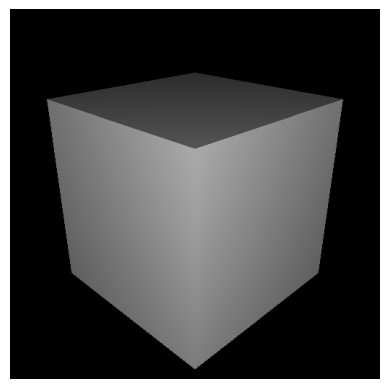

In [7]:
# Create cube SDF buffer
cube_sdfs = spy.NDBuffer(
    device=device,
    dtype=renderer_modules.primitive_module.CubeSDF.as_struct(),
    shape=(1,),
)

model_matrix = Transform3D(
    position=glm.vec3(0.0, 0.0, 0.0),
    rotation=glm.quat(1.0, 0.0, 0.0, 0.0),
    scale=glm.vec3(1.0, 1.0, 1.0)
).get_matrix()

inv_model_matrix = glm.inverse(model_matrix)

cube_cursor = cube_sdfs.cursor()
cube_cursor[0].write({
    "size": [1.0, 1.0, 1.0],
    "invModelMatrix": inv_model_matrix,
})
cube_cursor.apply()


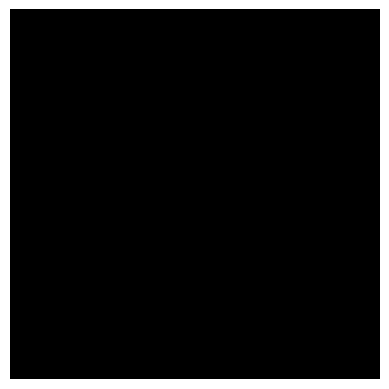

In [8]:
cam = PerspectiveCamera()
cam_pos = glm.vec3(3.0, 2.0, 3.0)
cam.transform.position = cam_pos
cam.transform.rotation = glm.quatLookAt(glm.normalize(-cam_pos), glm.vec3(0.0, 1.0, 0.0))
renderer.load_sdf_cubes(cube_buffer=cube_sdfs, cube_count=1)
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Boolean Operations on SDFs

A powerful feature of SDFs is that we can easily combine multiple SDFs using boolean operations such as union, intersection, and difference.

We provided these three basic operations in `src/cs248a_renderer/slang_shaders/primitive/sdf.slang` and a `CustomSDF` struct that uses the boolean operations to combine multiple SDFs.

In the implementation we provided, we subtract a sphere from a cube to create a cube with a spherical hole in it. You should be able to see the rendered result as below:

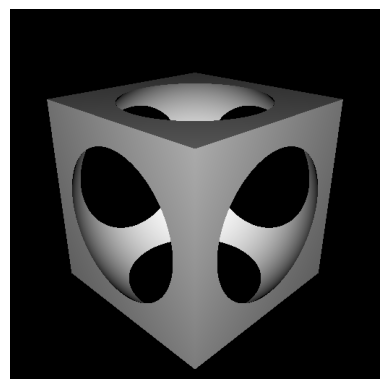

try to modify the `CustomSDF` to create other interesting shapes by combining multiple SDFs!

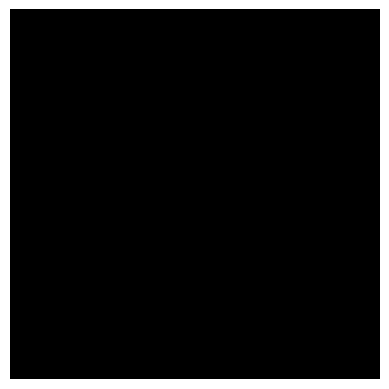

In [9]:
renderer.set_custom_sdf(
    custom_sdf={
        "cubeSize": [1.0, 1.0, 1.0],
        "sphereRadius": 1.25,
        "invModelMatrix": np.identity(4, dtype=np.float32),
    },
    render_custom_sdf=True,
)
renderer._sphere_sdf_count = 0
renderer._cube_sdf_count = 0
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()